## Mnist Clan-ssifier ;)

Here we demonstrate how to use the EZKL package to build an MNIST classifier for on-chain handrawn digit recognition.
The proofs get submitted to a contract that assigns the users account to a digit clan (0-9). The contract keeps track of the member count of each clan. The clan with the most members is the winner!

![zk-gaming-diagram-transformed](https://file.notion.so/f/f/f9535faf-4480-4499-9059-a48ba240eaa9/cd13414a-ecd8-4b8f-90a1-8a2311baa278/Untitled.png?id=365d66ee-e653-4ec3-8eb6-6d2b6306455a&table=block&spaceId=f9535faf-4480-4499-9059-a48ba240eaa9&expirationTimestamp=1701568800000&signature=VJ9p3YsOjYjeLxmkVEWOJw_3VmM6IBkTYxMwQUFKeus&downloadName=Untitled.png)
> **A typical ZK application flow**. For all the image classifictiton hackers out there — this is an fairly straight forward example. A user computes a ZKML-proof that they have calculated a valid classification of a hand drawn digit from a MNIST trained lenet model. They submit this proof to a verifier contract which governs a set of clans, along with the output values of the model (length 10 tensor whereby the index with the max value represented the prediction), and the clan count updates according the lenets model's prediction.

In [2]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchvision"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tf2onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

# make sure you have the dependencies required here already installed
import ezkl
import os
import json
import time
import random
import logging
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)

# Set device to GPU if available, else CPU
device = torch.device('cuda' if cuda_available else 'cpu')
print('Using device:', device)

# Display CPU information
print("CPU Information:")
!cat /proc/cpuinfo | grep "model name"

# Display memory information
print("\nMemory Information:")
!cat /proc/meminfo | grep "MemTotal"

# Display disk space information
print("\nDisk Space Information:")
!df -h

# Get GPU name and memory info if using GPU
if cuda_available:
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Memory Cached:", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

# uncomment for more descriptive logging
FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)
logging.getLogger().setLevel(logging.INFO)

CUDA Available: False
Using device: cpu
CPU Information:
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz

Memory Information:
MemTotal:       13290460 kB

Disk Space Information:
Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   33G   75G  31% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs           6.4G  388K  6.4G   1% /var/colab
/dev/sda1        77G   58G   20G  75% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional encoder
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional block
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


In [4]:
import numpy as np
import os
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.optim import Adam  # Import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

def normalize_img(image, label):
  return torch.round(image), label

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256
train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(), download=True)
test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model = LeNet().to(device)
adam = Adam(model.parameters())  # Using Adam with a learning rate of 1e-3
loss_fn = CrossEntropyLoss()
all_epoch = 10
prev_acc = 0
for current_epoch in range(all_epoch):
    model.train()
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        # normalize the image to 0 or 1 to reflect the inputs from the drawing board
        train_x = train_x.round()
        train_label = train_label.to(device)
        adam.zero_grad()  # Use adam optimizer
        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        loss.backward()
        adam.step()  # Use adam optimizer
    all_correct_num = 0
    all_sample_num = 0
    model.eval()

    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
         # normalize the image to 0 or 1 to reflect the inputs from the drawing board
        test_x = test_x.round()
        test_label = test_label.to(device)
        predict_y = model(test_x.float()).detach()
        predict_y = torch.argmax(predict_y, dim=-1)
        current_correct_num = predict_y == test_label
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num
    print('test accuracy: {:.3f}'.format(acc), flush=True)
    if not os.path.isdir("models"):
        os.mkdir("models")
    torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
    prev_acc = acc


test accuracy: 0.947
test accuracy: 0.965
test accuracy: 0.970
test accuracy: 0.971
test accuracy: 0.971
test accuracy: 0.972
test accuracy: 0.972
test accuracy: 0.974
test accuracy: 0.978
test accuracy: 0.977


tensor(7.1823e-08, grad_fn=<MinBackward1>)


Text(0.5, 1.0, 'Absolute value of parameters')

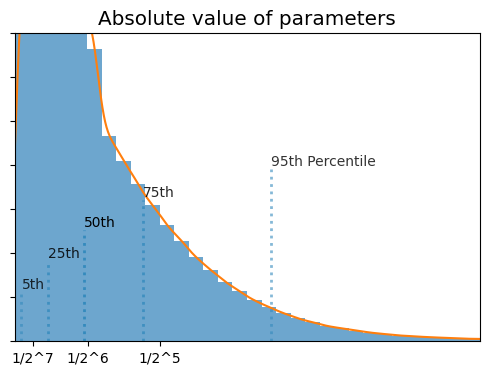

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from scipy import stats
n_bins = 100
# whats the smallest parameter in this model ?
minimum_abs_val = 100000
params_abs = []
for param in model.parameters():
  if param.abs().min() < minimum_abs_val:
    minimum_abs_val = param.abs().min()
  params_abs.extend(param.abs().detach().numpy().flatten().tolist())

print(minimum_abs_val)

xx = np.linspace(0, 0.2, 1000)

kde = stats.gaussian_kde(params_abs)
fig, ax = plt.subplots(figsize = (6,4))

ax.set_xlim(0, 0.2)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = ax.hist(params_abs, bins=n_bins, density = True, alpha =0.65)
ax.plot(xx, kde(xx))


ax.set_ylim(0, 14)
ax.set_yticklabels([])
ax.set_ylabel("")
plt.style.use("bmh")
ax.set_xticks([1.0/128.0, 1.0/32.0, 1.0/16.0])
ax.set_xticklabels(["1/2^7", "1/2^6", "1/2^5"])
ax.grid(False)
# Calculate percentiles
quant_5, quant_25, quant_50, quant_75, quant_95 = np.quantile(params_abs, 0.05), np.quantile(params_abs, 0.25), np.quantile(params_abs, 0.5), np.quantile(params_abs, 0.75), np.quantile(params_abs, 0.95)

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

# Plot the lines with a loop
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

# Annotations
ax.text(quant_5, 14 * 0.17, "5th", size = 10, alpha = 0.8)
ax.text(quant_25, 14 * 0.27, "25th", size = 10, alpha = 0.85)
ax.text(quant_50, 14 * 0.37, "50th", size = 10, alpha = 1)
ax.text(quant_75, 14 * 0.47, "75th", size = 10, alpha = 0.85)
ax.text(quant_95, 14 * 0.57, "95th Percentile", size = 10, alpha =.8)

ax.set_title("Absolute value of parameters")

In [6]:
import os

model_path = os.path.join('network_lenet.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('key.pk')
vk_path = os.path.join('key.vk')
settings_path = os.path.join('settings.json')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [7]:
import torch
import json

model.eval()  # Set the model to evaluation mode

# # Fetch a single data point from the train_dataset
# # Ensure train_dataset is already loaded and accessible
train_data_point, _ = next(iter(train_dataset))
train_data_point = train_data_point.unsqueeze(0)  # Add a batch dimension

# Verify the device (CPU or CUDA) and transfer the data point to the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_data_point = train_data_point.to(device)

# # Export the model to ONNX format
torch.onnx.export(model, train_data_point, model_path, export_params=True, opset_version=12, do_constant_folding=True, input_names=['input_0'], output_names=['output'])

# Convert the tensor to numpy array and reshape it for JSON serialization
x = train_data_point.cpu().detach().numpy().reshape([-1]).tolist()
data = {'input_data': [x]}
with open('input.json', 'w') as f:
    json.dump(data, f)

print(f"Model exported to {model_path} and input data saved to input.json")

Model exported to network_lenet.onnx and input data saved to input.json


In [8]:
import ezkl

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "private"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
run_args.num_inner_cols = 2
run_args.variables = [("batch_size", 1)]

# Capture set of data points
num_data_points = 8

# Fetch 30 data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(train_dataset):
    if i >= num_data_points:
        break
    data_points.append(data_point)

# Stack the data points to create a batch
train_data_batch = torch.stack(data_points)

# Add a batch dimension if not already present
if train_data_batch.dim() == 3:
    train_data_batch = train_data_batch.unsqueeze(0)

x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

data = dict(input_data = [x])

cal_path = os.path.join('cal_data.json')

# Serialize data into file:
json.dump( data, open(cal_path, 'w' ))

!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[2,7])
assert res == True

INFO:ezkl.execute:num calibration batches: 8

 <------------- Numerical Fidelity Report (input_scale: 2, param_scale: 2, scale_input_multiplier: 10) ------------->

+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| mean_error | median_error | max_error | min_error  | mean_abs_error | median_abs_error | max_abs_error | min_abs_error | mean_squared_error | mean_percent_error | mean_abs_percent_error |
+------------+--------------+-----------+------------+----------------+------------------+---------------+---------------+--------------------+--------------------+------------------------+
| -3.147646  | -8.930053    | 16.644749 | -22.649399 | 6.244274       | 8.930053         | 22.649399     | 0.04547668    | 61.693016          | 1.1370605          | 1.611659               |
+------------+--------------+-----------+------------+----------------+----

In [9]:
res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

In [10]:
# srs path
res = await ezkl.get_srs(settings_path)

INFO:ezkl.execute:SRS already exists at that path
INFO:ezkl.execute:read 4194564 bytes from file (vector of len = 4194564)
INFO:ezkl.execute:file hash: 90807800a1c3b248a452e1732c45ee5099f38b737356f5542c0584ec9c3ebb45


In [11]:
# now generate the witness file
witness_path = "witness.json"

res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
assert os.path.isfile(witness_path)

In [12]:
res = ezkl.mock(witness_path, compiled_model_path)
assert res == True

INFO:ezkl.execute:Mock proof
INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"


In [13]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"
INFO:ezkl.pfsys:VK took 5.650
INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"
INFO:ezkl.pfsys:PK took 6.294
INFO:ezkl.pfsys:done saving verification key ✅
INFO:ezkl.pfsys:done saving proving key ✅


In [14]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        "single",
    )

print(res)
assert os.path.isfile(proof_path)

INFO:ezkl.pfsys:loaded proving key ✅
INFO:ezkl.pfsys:proof started...
INFO:ezkl.graph.model:model layout...
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_-1_1"
INFO:ezkl.circuit.table:Loading range check table from cache: "/root/.ezkl/cache/rangecheck_0_16383"
INFO:ezkl.pfsys:proof took 13.713


{'instances': [['fafeffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '55ffffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '4fffffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', 'b1ffffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', 'b0feffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '7e00000000000000000000000000000000000000000000000000000000000000', '03ffffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '53ffffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', 'e8feffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430', '9effffef93f5e1439170b97948e833285d588181b64550b829a031e1724e6430']], 'proof': '0x08488c1326de7044639b4e705fbecfe71959a9d1e5526c7db2a7211c5852b3872017ed46177c1e3d42319558b1af9c16494868d0922d4652de0eafcbaf7da8112567af32509fe8ba811c4c02be9902cceaf7d940c34b83fb792149442b427a2319b36e512719be326e4b8d09deeedd6de6d3c0100848285edbb242048a0aea4021020628d7cd2f462c3b67dc1450d0e843

In [15]:
# VERIFY IT
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
    )

assert res == True
print("verified")

INFO:ezkl.pfsys:loaded verification key ✅
INFO:ezkl.execute:verify took 0.7
INFO:ezkl.execute:verified: true


verified


We can now create an EVM / `.sol` verifier that can be deployed on chain to verify submitted proofs using a view function.

In [ ]:

abi_path = 'test.abi'
sol_code_path = 'test_1.sol'

res = await ezkl.create_evm_verifier(
        vk_path,
        settings_path,
        sol_code_path,
        abi_path,
    )
assert res == True

## Verify on the evm

In [ ]:
# Make sure anvil is running locally first
# run with $ anvil -p 3030
# we use the default anvil node here
import json

address_path = os.path.join("address.json")

res = await ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

with open(address_path, 'r') as file:
    addr = file.read().rstrip()

In [ ]:
# make sure anvil is running locally
# $ anvil -p 3030

res = await ezkl.verify_evm(
    addr,
    proof_path,
    "http://127.0.0.1:3030"
)
assert res == True